# analysis of altimetric data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from h3 import h3
import pyinterp
from xhistogram.xarray import histogram

In [2]:
plt_params = {'extent':[-75,20,-70,70],
              'dticks':[20,20],
              'projection': ccrs.PlateCarree(0)}
#              'projection': ccrs.Robinson(central_longitude=-30)}
#              'projection': ccrs.Mollweide()}

In [13]:
def plot(v, vmin=None, vmax=None, x='longitude_bin', y='latitude_bin', 
         figsize=(10,10), colorbar=True, colmap=None, colorbar_kwargs={}):
    _projection = plt_params['projection']
    _extent = plt_params['extent']
    _dticks = plt_params['dticks']
    #
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=_projection)
    ax.set_extent(_extent)
    im = v.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x=x, y=y, cmap=colmap, add_colorbar=False)
    if colorbar:
        cbar = fig.colorbar(im, **colorbar_kwargs)
    else:
        cbar = None
    # grid lines:
    xticks = np.arange(_extent[0],
                       _extent[1]+_dticks[0],
                       _dticks[1]*np.sign(_extent[1]-_extent[0]))
    ax.set_xticks(xticks,crs=ccrs.PlateCarree())
    yticks = np.arange(_extent[2],
                       _extent[3]+_dticks[1],
                       _dticks[1]*np.sign(_extent[3]-_extent[2]))
    ax.set_yticks(yticks,crs=ccrs.PlateCarree())
    gl = ax.grid()
    ax.add_feature(cfeature.LAND)
    #
    #if title is not None:
    #    ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})

---

## not used for now

In [4]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35680 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.66 GB


In [12]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10)

In [ ]:
cluster

---

## load data

In [5]:
# if on local computer:
ds = xr.open_zarr('/home2/pharos/othr/aponte/alti/tp')

In [ ]:
# if on cloud:
import gcsfs.mapping
fs = gcsfs.GCSFileSystem(project='pangeo-cnes', token=None)
gcsmap = gcsfs.mapping.GCSMap('pangeo-cnes/alti/tp', gcs=fs)
ds = xr.open_zarr(gcsmap, consolidated=True)

In [6]:
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds0 = ds
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<shape=(157384325,), chunksize=(1000000,)>
    longitude       (time) float64 dask.array<shape=(157384325,), chunksize=(1000000,)>
  * time            (time) datetime64[ns] 1993-03-02T23:44:00.992296960 ... 2002-01-03T23:20:19.861993216
Data variables:
    cycle           (time) int16 dask.array<shape=(157384325,), chunksize=(1000000,)>
    dac             (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    lwe             (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    mdt             (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    ocean_tide      (time) float64 dask.array<shape=(157384325,), chunksize=(1000000,)>
    sla_filtered    (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    sla_unfiltered  (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    track           

### description of each variables
<img src="capture.png">

- SSH : Sea Surface Height
- MDT : Mean Dynamic Topography (temporal mean of the SSH above the Geoid over a period N)
- MSS : Mean Sea Surface (temporal mean of the SSH over a period N)
- SLA : Sea Level Anomaly deduced from the SSH using a MMS
- dac : Dynamic Atmospheric correction
- sla_filtered : Sea level anomaly
- sla_unfiltered : Sea level anomaly





---

## xhistogram 

In [7]:
ds = ds0
ds = ds0.isel(time=slice(0,int(1e7)))
ds['longitude'] = (ds.longitude+180)%360 - 180
ds = ds.where((ds.longitude<10)&(ds.longitude>-70), drop=True)

In [8]:
lon_bins = np.arange(-70, 10, 1)
lat_bins = np.arange(-70, 70, 1)

N = histogram(ds.longitude, ds.latitude, bins=[lon_bins, lat_bins]).persist()

sla_mean = (histogram(ds.longitude, ds.latitude, 
                      bins=[lon_bins, lat_bins], weights=ds.sla_filtered)/N) \
            .rename('sla_mean').persist()

sla2_mean = (histogram(ds.longitude, ds.latitude, 
                       bins=[lon_bins, lat_bins], weights=ds.sla_filtered**2)/N)\
            .rename('sla2_mean').persist()

In [9]:
sla_mean

<xarray.DataArray 'sla_mean' (longitude_bin: 79, latitude_bin: 139)>
dask.array<shape=(79, 139), dtype=float64, chunksize=(79, 139)>
Coordinates:
  * longitude_bin  (longitude_bin) float64 -69.5 -68.5 -67.5 ... 6.5 7.5 8.5
  * latitude_bin   (latitude_bin) float64 -69.5 -68.5 -67.5 ... 66.5 67.5 68.5

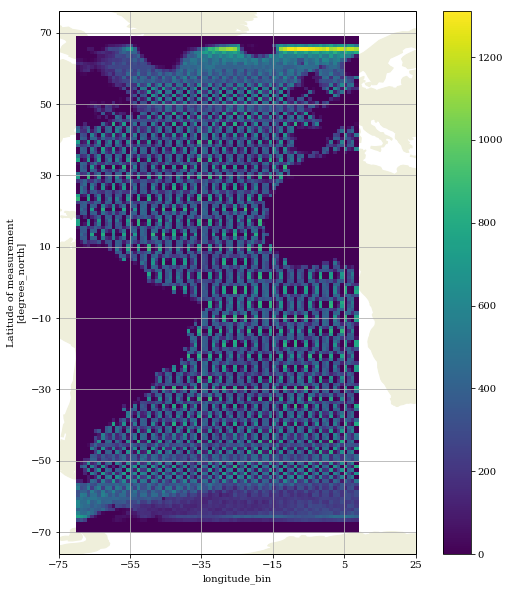

In [15]:
plot(N)

In [16]:
ds.time.max()

<xarray.DataArray 'time' ()>
array('1993-12-30T21:21:11.105027584', dtype='datetime64[ns]')

In [17]:
ds.time.min()

<xarray.DataArray 'time' ()>
array('1992-12-31T23:20:35.775270144', dtype='datetime64[ns]')

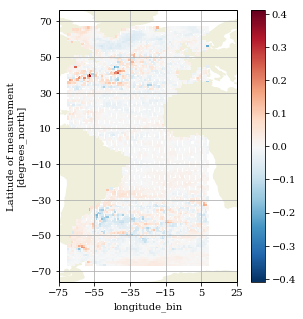

In [10]:
plot(sla_mean)

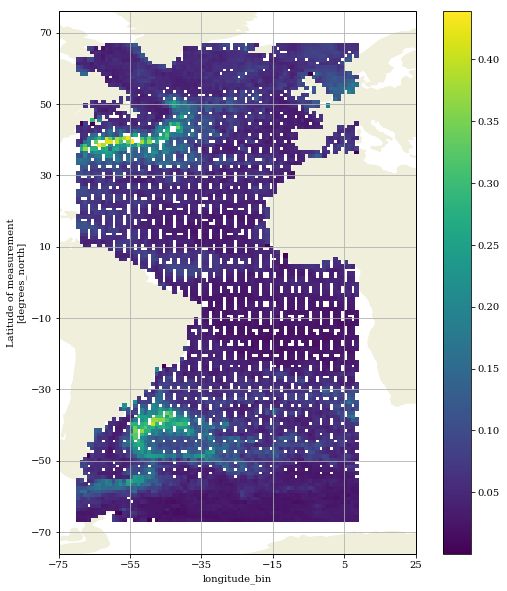

In [14]:
plot(np.sqrt(sla2_mean-sla_mean**2))

---
## pyinterp approach

[pyinterp doc](https://pangeo-pyinterp.readthedocs.io/en/latest/examples.html)

In [9]:
ds = ds0.isel(time=slice(0,int(1e8))).chunk({'time':1e6})
#ds = ds0.where((ds.longitude<45)&(ds.longitude>-45), drop=True)
#ds = ds0 # crashes
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

Dataset size = 5.6 GB


In [10]:
ds = ds.persist()

In [15]:
binning = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(-180, 180, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 95, 1)))

In [ ]:
#mx, my = np.meshgrid(ds.longitude, ds.latitude)
binning.push(ds.longitude, ds.latitude, ds.mdt, simple=True)

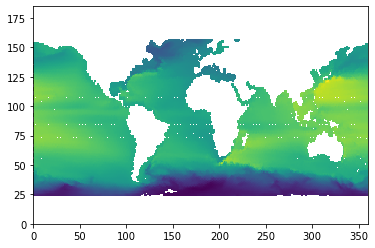

In [13]:
plt.pcolormesh(binning.variable('mean').T)

In [ ]:
binning.variable('mean')

In [1]:
np.asarray(ds.mdt).flatten().shape

NameError: name 'np' is not defined

---
## h3

In [ ]:
ds = ds.isel(time=slice(0,int(1e6)))
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

df = ds.to_dataframe()
df

In [ ]:
resolution = 7
%time df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)

In [ ]:
df

In [ ]:
df_stats = df.groupby('hex_id').mean()